## Importing the Required Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
plt.style.use('fivethirtyeight')
print(tf.__version__)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(filename)

2.4.1
labeled_data.csv
glove.6B.100d.txt


## Reading the Dataset

In [4]:
df = pd.read_csv('../input/hate-speech-and-offensive-language-dataset/labeled_data.csv')
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
nRow, nCol = df.shape
print('There are {} rows and {} columns'.format(nRow, nCol))

There are 24783 rows and 7 columns


In [6]:
c=df['class']
df.rename(columns={'tweet' : 'text',
                   'class' : 'category'}, 
                    inplace=True)
a=df['text']
b=df['category'].map({0: 'hate_speech', 1: 'offensive_language',2: 'neither'})

df= pd.concat([a,b,c], axis=1)
df.rename(columns={'class' : 'label'}, 
                    inplace=True)
df

,text,category,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1
...,...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,offensive_language,1
24779,"you've gone and broke the wrong heart baby, an...",neither,2
24780,young buck wanna eat!!.. dat nigguh like I ain...,offensive_language,1
24781,youu got wild bitches tellin you lies,offensive_language,1


In [10]:
# Grouping data by label
df['category'].value_counts()

offensive_language    19190
neither                4163
hate_speech            1430
Name: category, dtype: int64

In [12]:
hate, ofensive, neither = np.bincount(df['label'])
total = hate + ofensive + neither
print('Examples:\n    Total: {}\n    hate: {} ({:.2f}% of total)\n'.format(
    total, hate, 100 * hate / total))
print('Examples:\n    Total: {}\n    Ofensive: {} ({:.2f}% of total)\n'.format(
    total, ofensive, 100 * ofensive / total))
print('Examples:\n    Total: {}\n    Neither: {} ({:.2f}% of total)\n'.format(
    total, neither, 100 * neither / total))

Examples:
    Total: 24783
    hate: 1430 (5.77% of total)

Examples:
    Total: 24783
    Ofensive: 19190 (77.43% of total)

Examples:
    Total: 24783
    Neither: 4163 (16.80% of total)



## Splitting the Dataset into train, val and test sets

In [13]:
X_train_, X_test, y_train_, y_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.label.values,    
)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    df.loc[X_train_].index.values,
    df.loc[X_train_].label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.loc[X_train_].label.values,  
)

In [15]:
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

In [16]:
df.groupby(['category', 'label', 'data_type']).count()

text
category           label data_type       
hate_speech        0     test         143
                         train       1158
                         val          129
neither            2     test         416
                         train       3372
                         val          375
offensive_language 1     test        1920
                         train      15543
                         val         1727

In [17]:
df

,text,category,label,data_type
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,2,test
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1,train
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1,train
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1,train
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1,train
...,...,...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,offensive_language,1,train
24779,"you've gone and broke the wrong heart baby, an...",neither,2,train
24780,young buck wanna eat!!.. dat nigguh like I ain...,offensive_language,1,train
24781,youu got wild bitches tellin you lies,offensive_language,1,train


In [18]:
df_train = df.loc[df["data_type"]=="train"]
df_val = df.loc[df["data_type"]=="val"]
df_test = df.loc[df["data_type"]=="test"]

df_train.head()

,text,category,label,data_type
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1,train
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1,train
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1,train
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1,train
6,"!!!!!!""@__BrighterDays: I can not just sit up ...",offensive_language,1,train


In [24]:
df_train_plus_val = pd.concat([df_train,df_val], axis=0)
df_train_plus_val.head()

,text,category,label,data_type
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1,train
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1,train
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1,train
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1,train
6,"!!!!!!""@__BrighterDays: I can not just sit up ...",offensive_language,1,train


In [25]:
x = df_train_plus_val.text.values
y = df_train_plus_val.label.values

In [20]:
max_features = 20000
max_text_length = 512

In [26]:
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))

In [28]:
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val= sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

In [37]:
x_test_tokenized = x_tokenizer.texts_to_sequences(df_test.text.values)
x_test = sequence.pad_sequences(x_test_tokenized,maxlen=max_text_length)

#### Loading the Glove vector embeddings

In [29]:
embedding_dim =100
embeddings_index = dict()
f = open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word]= coefs
f.close()
print(f'Found {len(embeddings_index)} word vectors')

Found 400000 word vectors


In [30]:
embedding_matrix= np.zeros((max_features,embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index>max_features-1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index]= embedding_vector

In [33]:
y_train_plus_val =  tf.keras.utils.to_categorical(y, num_classes=3)
y_test =  tf.keras.utils.to_categorical(df_test.label, num_classes=3)
y_train_plus_val

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

# Building 1 D CNN Model

In [46]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))

model.add(Dropout(0.2))

model.add(Conv1D(64,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(64,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())

model.add(Conv1D(32,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(32,2,padding='valid',activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         2000000   
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 64)          12864     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 64)          8256      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 32)         

In [47]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

## Training Model

In [48]:
history = model.fit(x_train_val, y_train_plus_val, batch_size= 64, validation_split=0.2, epochs=10)

Epoch 1/10
279/279 [==============================] - 4s 11ms/step - loss: 0.6695 - accuracy: 0.7670 - val_loss: 0.4313 - val_accuracy: 0.8514
Epoch 2/10
279/279 [==============================] - 3s 10ms/step - loss: 0.4421 - accuracy: 0.8453 - val_loss: 0.3916 - val_accuracy: 0.8662
Epoch 3/10
279/279 [==============================] - 3s 10ms/step - loss: 0.4119 - accuracy: 0.8559 - val_loss: 0.4008 - val_accuracy: 0.8628
Epoch 4/10
279/279 [==============================] - 3s 11ms/step - loss: 0.3925 - accuracy: 0.8629 - val_loss: 0.3645 - val_accuracy: 0.8740
Epoch 5/10
279/279 [==============================] - 3s 10ms/step - loss: 0.3665 - accuracy: 0.8697 - val_loss: 0.3555 - val_accuracy: 0.8772
Epoch 6/10
279/279 [==============================] - 3s 10ms/step - loss: 0.3488 - accuracy: 0.8732 - val_loss: 0.3541 - val_accuracy: 0.8769
Epoch 7/10
279/279 [==============================] - 3s 10ms/step - loss: 0.3370 - accuracy: 0.8804 - val_loss: 0.3657 - val_accuracy: 0.8713

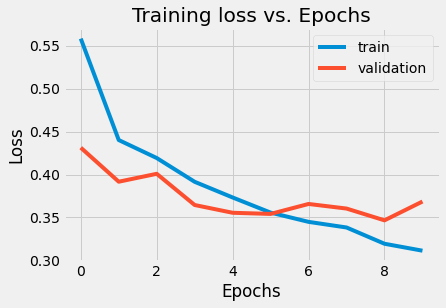

In [49]:
# Plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss vs. Epochs')
plt.legend()
plt.show()

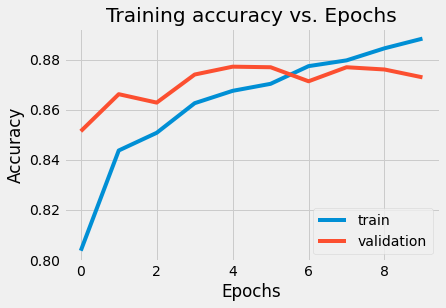

In [50]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs. Epochs')
plt.legend()
plt.show()

### Evaluating Model

In [51]:
model.evaluate(x_test,y_test, batch_size = 64)

39/39 [==============================] - 0s 9ms/step - loss: 0.3772 - accuracy: 0.8596


[0.3772042691707611, 0.8596208095550537]

In [56]:
y_pred = model.predict(x_test)
y_pred

array([[1.7667225e-02, 1.3389394e-01, 8.4843880e-01],
       [1.4384475e-02, 9.8523754e-01, 3.7794383e-04],
       [1.6320808e-02, 9.8360068e-01, 7.8489655e-05],
       ...,
       [2.2049075e-01, 7.4004710e-01, 3.9462157e-02],
       [2.2852251e-01, 7.6911455e-01, 2.3629020e-03],
       [2.7945631e-03, 9.9719137e-01, 1.4033035e-05]], dtype=float32)

In [57]:
y_pred = np.array( [ np.argmax (y) for y in y_pred ] )

In [58]:
y_pred

array([2, 1, 1, ..., 1, 1, 1])

In [61]:
y_test_labels = df_test.label

### Plotting Confusion Matrix

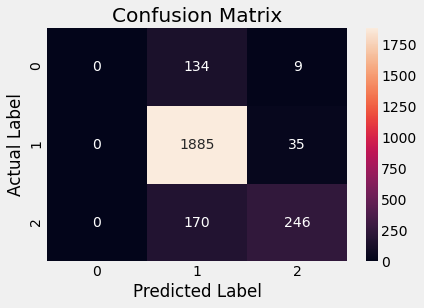

In [62]:
cm = confusion_matrix(y_test_labels, y_pred)
fig = sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show(fig)

### Saving the Model

In [63]:
model.save('hate_davidson_dataset_1dcnn_glove.h5')